In [71]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense,TimeDistributed, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from keras import callbacks

In [72]:
data_set_contaminantes = pd.read_csv('../../../data/processed/normalizados/Dataset_MinMax.csv',sep=';',decimal=',')
data_set_contaminantes['fecha'] = pd.to_datetime(data_set_contaminantes['fecha'])
data_set_contaminantes.sort_values('fecha', inplace=True)
data_set_contaminantes.columns


Index(['fecha', 'pm2.5', 'pm10', 'humedad', 'puntoRocio', 'temperatura',
       'viento', 'precipitacion', 'AQI', 'calidad_aire', 'year', 'mes',
       'mes_sin', 'mes_cos', 'dia', 'dia_sin', 'dia_cos'],
      dtype='object')

In [73]:
data_set_contaminantes = data_set_contaminantes.drop('fecha', axis=1)
data_set_contaminantes = data_set_contaminantes.drop('calidad_aire', axis=1)

data_set_contaminantes = data_set_contaminantes.drop(columns=['year','dia','mes','dia_sin' , 'dia_cos'],axis=1)
data_set_contaminantes.columns

Index(['pm2.5', 'pm10', 'humedad', 'puntoRocio', 'temperatura', 'viento',
       'precipitacion', 'AQI', 'mes_sin', 'mes_cos'],
      dtype='object')

In [74]:
def create_sequences(df, target_columns, n_steps, horizon):
    X, y = [], []
    for i in range(len(df) - n_steps - horizon + 1):
        seq_x = df.iloc[i:i + n_steps].values
        seq_y = df.iloc[i + n_steps:i + n_steps + horizon][target_columns].values
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps = 1 
horizon = 1  
target_columns = ['pm2.5', 'pm10']

X, y = create_sequences(data_set_contaminantes, target_columns, n_steps, horizon)



In [75]:
# Dividir los datos en conjuntos de entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)
print(X_train.shape)
print(y_train.shape)



(2991, 1, 10)
(2991, 1, 2)


In [76]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # cantidad mínima de cambio para contar como una mejora
    patience=200, # cuántas épocas esperar antes de detener
    restore_best_weights=True,
)

model = Sequential()

model.add(
    SimpleRNN(units=64, 
              activation="relu", 
              return_sequences=True,
              input_shape=(X_train.shape[1], X_train.shape[2]))
)
model.add(Dropout(0.1))


# model.add(SimpleRNN(units=64, activation="relu",return_sequences=True))


# model.add(Dropout(0.25))


model.add(SimpleRNN(units=32, activation="relu",return_sequences=True))
model.add(Dropout(0.1))




model.add(SimpleRNN(units=16, activation="relu",return_sequences=True))



model.add(SimpleRNN(units=8, activation="relu",return_sequences=True))



# model.add(SimpleRNN(units=4, activation="relu",return_sequences=True))


# La capa de salida para la predicción de los valores pm2.5 y pm10.
model.add(TimeDistributed(Dense(units=2)))
# model.add(Dense(units=2))



opt = Adam(learning_rate=0.00005)
model.compile(optimizer=opt, loss='mse')

print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_20 (SimpleRNN)   (None, 1, 64)             4800      
                                                                 
 dropout_11 (Dropout)        (None, 1, 64)             0         
                                                                 
 simple_rnn_21 (SimpleRNN)   (None, 1, 32)             3104      
                                                                 
 dropout_12 (Dropout)        (None, 1, 32)             0         
                                                                 
 simple_rnn_22 (SimpleRNN)   (None, 1, 16)             784       
                                                                 
 simple_rnn_23 (SimpleRNN)   (None, 1, 8)              200       
                                                                 
 time_distributed_5 (TimeDi  (None, 1, 2)             

In [77]:
history = model.fit(X_train, y_train, epochs=100, batch_size=20, validation_split=0.2, verbose=0,callbacks=[early_stopping])
y_pred = model.predict(X_test)
print(y_pred)

24/24 [==============================] - 0s 1ms/step
[[[0.04124297 0.08454148]]

 [[0.18669686 0.19707969]]

 [[0.03025617 0.05659969]]

 ...

 [[0.06117607 0.12336387]]

 [[0.03574869 0.07701443]]

 [[0.07800996 0.14352493]]]


In [78]:
print(y_pred.shape)

(748, 1, 2)


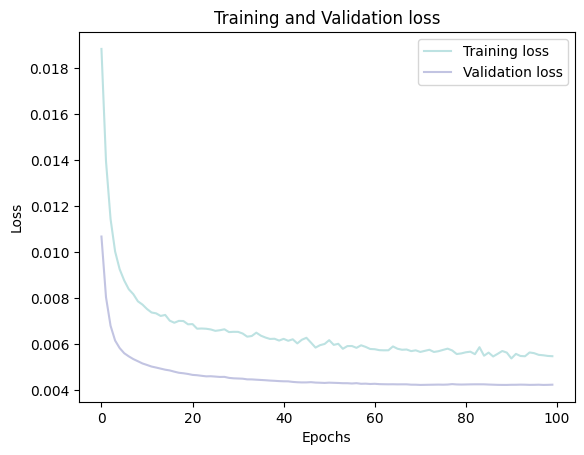

In [79]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], "#BDE2E2", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#C2C4E2", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

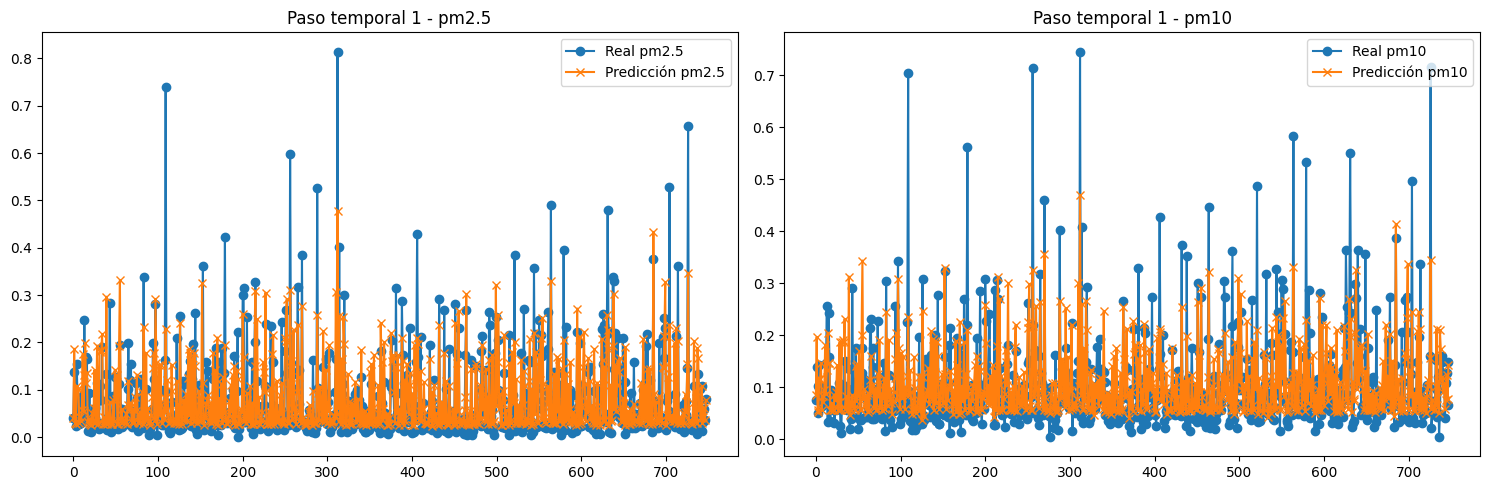

In [80]:
# Extraer y aplanar las predicciones y los valores reales para cada paso temporal
# horizon= 2
fig, axes = plt.subplots(horizon, 2, figsize=(15, 5*horizon), squeeze=False)

for i in range(horizon):
    # Datos reales para el paso temporal i
    real_time_step_data = y_test[:, i, :]
    # Predicciones para el paso temporal i
    pred_time_step_data = y_pred[:, i, :]

    # Graficar los datos reales y las predicciones para pm2.5
    axes[i][0].plot(real_time_step_data[:, 0], 'o-', label='Real pm2.5')
    axes[i][0].plot(pred_time_step_data[:, 0], 'x-', label='Predicción pm2.5')
    axes[i][0].set_title(f'Paso temporal {i+1} - pm2.5')
    axes[i][0].legend()

    # Graficar los datos reales y las predicciones para pm10
    axes[i][1].plot(real_time_step_data[:, 1], 'o-', label='Real pm10')
    axes[i][1].plot(pred_time_step_data[:, 1], 'x-', label='Predicción pm10')
    axes[i][1].set_title(f'Paso temporal {i+1} - pm10')
    axes[i][1].legend()

# Ajustar el layout y mostrar el gráfico
plt.tight_layout()
plt.show()



In [81]:
print('y_pred',y_pred)
print('y_test',y_test)

print(y_pred.shape)


y_pred [[[0.04124297 0.08454148]]

 [[0.18669686 0.19707969]]

 [[0.03025617 0.05659969]]

 ...

 [[0.06117607 0.12336387]]

 [[0.03574869 0.07701443]]

 [[0.07800996 0.14352493]]]
y_test [[[0.0413 0.0749]]

 [[0.1377 0.1399]]

 [[0.0426 0.1025]]

 ...

 [[0.0589 0.1276]]

 [[0.0354 0.0664]]

 [[0.0809 0.1495]]]
(748, 1, 2)


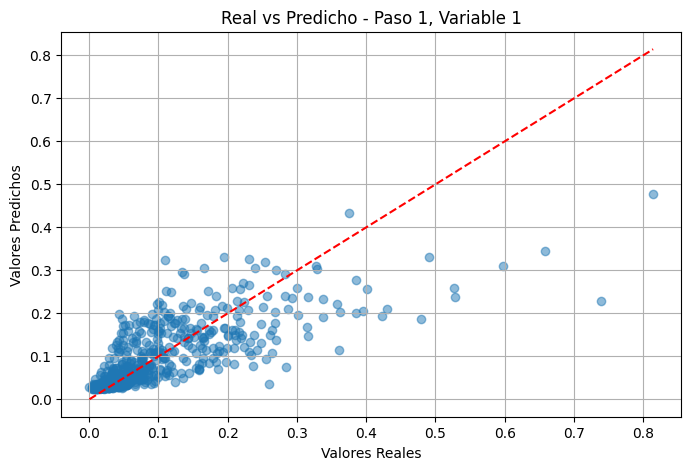

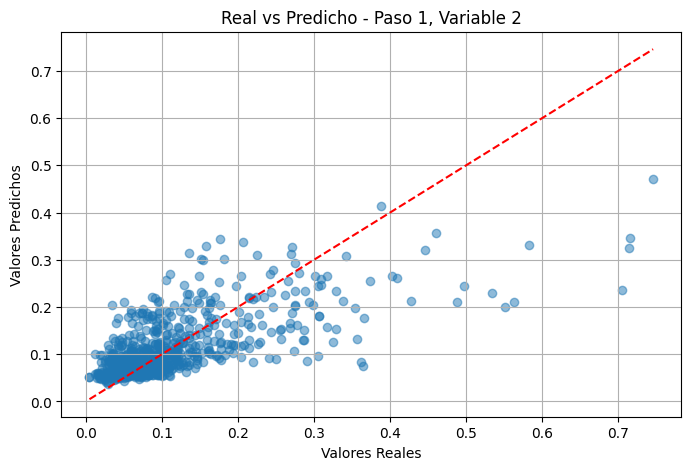

In [82]:
import matplotlib.pyplot as plt
for i in range(horizon):
    for j in range(y_pred.shape[2]): 
        plt.figure(figsize=(8, 5))
        plt.scatter(y_test[:, i, j], y_pred[:, i, j], alpha=0.5)
        min_val = min(y_test[:, i, j].min(), y_pred[:, i, j].min())
        max_val = max(y_test[:, i, j].max(), y_pred[:, i, j].max())

        # diagonal
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal')
        plt.title(f'Real vs Predicho - Paso {i+1}, Variable {j+1}')
        plt.xlabel('Valores Reales')
        plt.ylabel('Valores Predichos')
        plt.grid(True)
        plt.show()


In [83]:
mse_per_step = []
rmse_per_step = []
mae_per_step = []
r2_per_step = []


import pickle

# Cargar el MinMaxScaler
with open('../../scaler_minmax.pkl', 'rb') as file:
    loaded_scaler = pickle.load(file)


# Indices de las características que mantuviste
features_indices = [0, 1] # Por ejemplo, si mantuviste las dos primeras características

# Crear un nuevo MinMaxScaler
scaler_for_selected_features = MinMaxScaler()

# Asumiendo que 'loaded_scaler' es tu escalador original cargado con pickle
scaler_for_selected_features.min_ = loaded_scaler.min_[features_indices]
scaler_for_selected_features.scale_ = loaded_scaler.scale_[features_indices]
scaler_for_selected_features.data_min_ = loaded_scaler.data_min_[features_indices]
scaler_for_selected_features.data_max_ = loaded_scaler.data_max_[features_indices]
scaler_for_selected_features.data_range_ = loaded_scaler.data_range_[features_indices]

# Ahora usa este nuevo escalador para desnormalizar tus datos
y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])
y_pred_reshaped = y_pred.reshape(-1, y_pred.shape[-1])

y_test_original = scaler_for_selected_features.inverse_transform(y_test_reshaped)
y_pred_original = scaler_for_selected_features.inverse_transform(y_pred_reshaped)

y_test = y_test_original.reshape(-1, 1, 2)
y_pred = y_pred_original.reshape(-1, 1, 2)


# Calcular las métricas para cada paso temporal y cada variable
for i in range(horizon):
    for j in range(2):
        # Calcular las métricas para la variable j en el paso temporal i
        mse_temporal = mean_squared_error(y_test[:, i, j], y_pred[:, i, j])
        rmse_temporal = np.sqrt(mse_temporal)
        mae_temporal = mean_absolute_error(y_test[:, i, j], y_pred[:, i, j])
        r2_temporal = r2_score(y_test[:, i, j], y_pred[:, i, j])
        
        # Agregar a las listas
        mse_per_step.append(mse_temporal)
        rmse_per_step.append(rmse_temporal)
        mae_per_step.append(mae_temporal)
        r2_per_step.append(r2_temporal)

# Mostrar las métricas

variable_dict = {
    0: 'Pm2.5',
    1: 'pm10'
}
metrics_data = {
    'Paso Temporal': [],
    'Variable': [],
    'MSE': [],
    'RMSE': [],
    'MAE': [],
    'R^2': []
}

# Llenar el DataFrame con las métricas calculadas
for i in range(horizon):
    for j in range(2):
        metrics_data['Paso Temporal'].append(i + 1)
        metrics_data['Variable'].append(variable_dict[j])
        idx = i * 2 + j  # Calcular el índice para las listas de métricas
        metrics_data['MSE'].append(mse_per_step[idx])
        metrics_data['RMSE'].append(rmse_per_step[idx])
        metrics_data['MAE'].append(mae_per_step[idx])
        metrics_data['R^2'].append(r2_per_step[idx])




# Convertir el diccionario en un DataFrame
metrics_df = pd.DataFrame(metrics_data)




In [84]:
metrics_df

,Paso Temporal,Variable,MSE,RMSE,MAE,R^2
0,1,Pm2.5,318.608649,17.849612,10.266190,0.601775
1,1,pm10,500.951108,22.381937,14.207076,0.484714
